# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Wei JIANG, Minghui SHI, Costanza VOLPINI

**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# Additional imports
from skimage import feature
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import ndimage
import skimage.measure as measure

from skimage.transform import rotate, AffineTransform, warp
import random
import cv2
import math
from numpy.linalg import inv

from scipy.interpolate import Rbf
from scipy.ndimage import morphology

from skimage.measure import regionprops, label
from matplotlib.patches import Ellipse
import plotly.express as px
import pandas as pd
from sklearn import decomposition

In [3]:
# Helper functions

# Convert contour into complex signals
def convert_signal(contour):
    '''
        Args: 
            contour: contour coordiante of images
        outputs:
            complex signal representation of contour
    '''
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,1] + 1j*contour[:,0] 
    return output

# Find outer contour and convert
def contour_fourier(images):
    '''
        Args: 
            images: input images
        outputs:
            contours of the images
    '''
    contour_out = []
    for im in images: 
        im = ndimage.binary_fill_holes(im) 
        im[im>0] =255
        contours = measure.find_contours(im, 0)
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_out.append(convert_signal(contour))
    return np.array(contour_out)



# Affine transform Helper functions: convertImg, affineTransform
# Convert image coordinates to matrix
def convertImg(img):   
    N = img.shape[0]
    # zero padding
    if N%2 == 0:
        img = np.pad(img, ((5,6),(5,6)), mode='constant',constant_values=0)
        N+=11
    else:
        img = np.pad(img, ((5,5),(5,5)), mode='constant',constant_values=0)
        N+=10
    x = np.arange(-(N//2), N//2+1)
    y = np.arange(-(N//2), N//2+1)


    xx, yy = np.meshgrid(x, y)
    out = []
    out.append(xx.reshape([1,-1]))
    out.append(yy.reshape([1,-1]))
    out.append(np.ones(yy.reshape([1,-1]).shape))
    out = np.array(out).squeeze()
    return xx,yy,img,out

def affineTransform(img, rotation, scaling, translation):

    xx,yy,img,imgvec = convertImg(img)
    # rotation
    if rotation:
        theta =  random.uniform(-np.pi, np.pi)
        a0 = 0
        a1 = math.cos(theta)
        a2 = math.sin(theta)
        b0 = 0
        b1 = -math.sin(theta)
        b2 = math.cos(theta)
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    # scaling
    if scaling:
        s =  random.uniform(0.8, 1.2)
        a0 = 0
        a1 = 1/s
        a2 = 0
        b0 = 0
        b1 = 0
        b2 = 1/s 
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    # translation
    if translation:
        tx =  random.randint(-2, 2)
        ty =  random.randint(-2, 2)
        a0 = -tx
        a1 = 1
        a2 = 0
        b0 = -ty
        b1 = 0
        b2 = 1        
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    xt = imgvec[0,:]
    yt = imgvec[1,:]
    
    # interpolation
    rbf = Rbf(xx, yy, img, epsilon=2)
    imgt = rbf(xt, yt)
    
    # normalize and threshold
    imgt = imgt- imgt.min()
    imgt = imgt/ (imgt.max()-imgt.min())
    t = 0.4
    imgt[imgt>= t] = 1
    imgt[imgt<t] = 0
    imgt = imgt*255
    
    return imgt.reshape(xx.shape)


# Plot images with contours
def plotImagContour(axes, contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
    for ax0, ax1, contour0, contour1,im0, im1, nm0, nm1 in zip(axes[0], axes[1], contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
        ax0.imshow(im0)
        ax0.step(np.real(contour0), np.imag(contour0), linewidth=2, c='r')
        ax0.axis('off')
        ax0.set_title(nm0)

        ax1.imshow(im1)
        ax1.step(np.real(contour1), np.imag(contour1), linewidth=2, c='r')
        ax1.axis('off')
        ax1.set_title(nm1)
        
        
# Skeletonize
def skeletonize(im):
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    size = np.size(im)
    skel = np.zeros(im.shape, np.uint8)
    while True:
        eroded = cv2.erode(im, element)
        im = eroded.copy()
        if cv2.countNonZero(im)==0:
            break
        open = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(eroded, open)
        skel = cv2.bitwise_or(skel,temp)
    skel[skel>0]=1
    return skel

# Fourier Descriptor

def get_fourier_descriptor(images_1, images_2, f1, f2, f_div, plot = False):
    # Contour detection
    contourf_0 = contour_fourier(images_1)
    contourf_1 = contour_fourier(images_2)


    FD_0 = np.zeros((10,2))
    FD_1 = np.zeros((10,2))

    for i in range(len(images_1)):

        fft0 = np.fft.fft(contourf_0[i])#,n = N)
        fft1 = np.fft.fft(contourf_1[i])#, n = N)

        # normalization
        if f_div == -1:
            FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])
                   
        else:
            FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[f_div])
    if plot:
        zeros = plt.scatter(FD_0[:,0], FD_0[:,1]) 
        ones = plt.scatter(FD_1[:,0], FD_1[:,1])
        plt.legend((zeros,ones),("0","1"))
        plt.show()
    return FD_0, FD_1

# Get 3 Fourier Descriptors

def get_fourier_descriptor_3(images_1, images_2, images_3, images_4, f1, f2, f3, f_div, plot = False):
    
    # Contour detection
    contourf_0 = contour_fourier(images_1)
    contourf_1 = contour_fourier(images_2)
    contourf_2 = contour_fourier(images_3)
    contourf_3 = contour_fourier(images_4)

    FD_0 = np.zeros((10,3))
    FD_1 = np.zeros((10,3))
    FD_2 = np.zeros((10,3))
    FD_3 = np.zeros((10,3))
    
    for i in range(len(images_1)):

        fft0 = np.fft.fft(contourf_0[i])#,n = N)
        fft1 = np.fft.fft(contourf_1[i])#, n = N)
        
        fft2 = np.fft.fft(contourf_2[i])#,n = N)
        fft3 = np.fft.fft(contourf_3[i])#, n = N)
        
        # normalization
        if f_div == -1:
            FD_0[i,:]  = np.abs([fft0[f1],fft0[f2],fft0[f3]] )  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1[i,:]  = np.abs([fft1[f1],fft1[f2],fft1[f3]] )
            FD_2[i,:]  = np.abs([fft2[f1],fft2[f2],fft2[f3]] )  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_3[i,:]  = np.abs([fft3[f1],fft3[f2],fft3[f3]])      
        else:
            FD_0[i,:]  = np.abs([fft0[f1],fft0[f2],fft0[f3]])/np.abs(fft0[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1[i,:]  = np.abs([fft1[f1],fft1[f2],fft1[f3]] )/np.abs(fft1[f_div])
            FD_2[i,:]  = np.abs([fft2[f1],fft2[f2],fft2[f3]] )/np.abs(fft2[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_3[i,:]  = np.abs([fft3[f1],fft3[f2],fft3[f3]] )/np.abs(fft3[f_div])  

    return FD_0, FD_1, FD_2, FD_3

# Chain code calculation (Freeman code)
# Code taken from pseudocode: http://www.cs.unca.edu/~reiser/imaging/chaincode.html 
def chain_code(im):
    '''
    Directions  0 1 2    Change in    -1  0  1   Change in    -1 -1 -1
               7 x 3    x-dimension  -1  0  1   y-dimension   0  0  0
               6 5 4                 -1  0  1                 1  1  1
    '''
    chain = []
    contour = [] #just for debug
    
    im = im.copy()
    start_r = 0
    start_c = 0
    # Find the first pixel on the boundary of the object. 
    for r in range(0, im.shape[0]):
        for c in range(0, im.shape[1]):
            if im[r][c] == 255:
                start_r = r
                start_c = c
                break
    
    # chain code
    directions = [0, 1, 2, 7, 3, 6, 5, 4]
    change_y = [-1, -1, -1, 0, 0, 1, 1, 1]
    change_x = [-1, 0, 1, -1, 1, -1, 0, 1]
    
    r = start_r
    c = start_c
    
    for index, d in enumerate(directions):
        if im[start_r + change_y[index], start_c + change_x[index]] == 255:
            r = start_r + change_y[index]
            c = start_c + change_x[index]
            contour.append((r, c))
            chain.append(d)
            break

    while (r != start_r) or (c != start_c):
        # decide where start
        b_direction = (d + 5) % 8
        dir1 = range(b_direction, 8)
        dir2 = range(0, b_direction)
        directions_ext = list(dir1) + list(dir2)
        for d in directions_ext:
            index = directions.index(d)
            if im[r + change_y[index], c + change_x[index]] == 255:
                r = r + change_y[index]
                c = c + change_x[index] 
                contour.append((r, c))
                chain.append(d)
                break
    return chain

# Edition distance calculation
# inspired by pseudo code on wikipedia: https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm
def editDistance(c1, c2):
    m = len(c1)
    n = len(c2)
    D = np.zeros([m,n])
    D[0,:] = range(n)
    D[:,0] = range(m)
    for i in range(1,m):
        for j in range(1,n):
            if c1[i] == c2[j]:
                D[i,j] = D[i-1, j-1]
            else:
                D[i,j]= np.min([D[i-1,j]+1, D[i,j-1]+1, D[i-1,j-1] + 1])
    return D[m-1,n-1]

# Elongation (Eclipse fitted) calculation and plot
def elongation_plot(img):
    label_img = label(img)
    [props] = regionprops(img)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    (y0, x0) = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    ellipse = Ellipse(xy=(x0, y0), width=props.minor_axis_length, height=props.major_axis_length, angle = 90 - orientation/3.14*180,
                        edgecolor='b', fc='None', lw=2)
    ax.add_patch(ellipse)
    plt.show()

# Rotate image
def rotate(img, theta):
    xx,yy,img,imgvec = convertImg(img)
    # rotation
    if rotation:
        a0 = 0
        a1 = math.cos(theta)
        a2 = math.sin(theta)
        b0 = 0
        b1 = -math.sin(theta)
        b2 = math.cos(theta)
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    xt = imgvec[0,:]
    yt = imgvec[1,:]
    
    # interpolation
    rbf = Rbf(xx, yy, img, epsilon=2)
    imgt = rbf(xt, yt)   
    # normalize and threshold
    imgt = imgt- imgt.min()
    imgt = imgt/ (imgt.max()-imgt.min())
    t = 0.4
    imgt[imgt>= t] = 1
    imgt[imgt<t] = 0
    imgt = imgt*255 
    return imgt.reshape(xx.shape)

# Calculate chamfer distance map from image
def get_distance_map(img):
    contours = np.array(measure.find_contours(img, 0))[0]
    cont = np.zeros_like(img)
    cont[contours[:,0].astype(int),contours[:,1].astype(int)]=1

    # Chamfer distance maps
    return morphology.distance_transform_cdt(1-cont)


## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

zeros_im[zeros_im>0] = 255
ones_im[ones_im>0] = 255

### 1.2 Fourier descriptors


We get contours of the 0s and 1s. We find the contours of 0s are very similar to a round shape while in 1s there are two diffrent writings. For example, the 1_5.png and 1_9.png use diffrent styles. We guess this may cause problems of outliers.

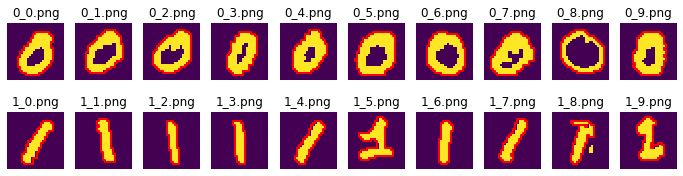

In [5]:
contourf_0 = contour_fourier(zeros_im)
contourf_1 = contour_fourier(ones_im)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names)

We find the three Fourier descriptors indexed 3, 5, 1(for devision) give us best clustering of 0s and 1s.

The reason of choosing these three is because of invarince to translation, scaling, rotation.  
We don't use the one indexed 0 to make it invariant to translation.   
We use additional one for devision(index 1) to make it invariant to scaling.   
We use the magtitude rather than phase in order to be invariant to rotation and different starting points.  

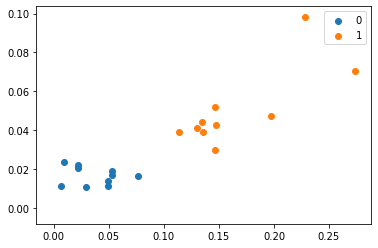

In [6]:
f1 = 3
f2 = 5
f_div = 1
FD_0, FD_1 = get_fourier_descriptor(zeros_im, ones_im, f1, f2, f_div, plot = True)

The result of clustering is good in general for distinguish 0s and 1s.    
The intra cluster variance in 1s is relatively higher because there are two 1s with different writing style compared to others.

Now we generate transformed data through rotation, translation, scaling to test invariance

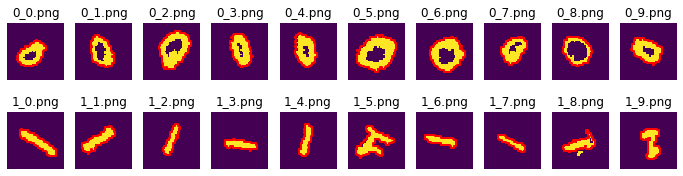

In [7]:
# Apply affine transformations with boolean flags and plot the results
rotation = True
scaling = True
translation = True

im_af0 = []
im_af1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform(img0, rotation, scaling, translation)
    img1 = affineTransform(img1, rotation, scaling, translation)
    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)


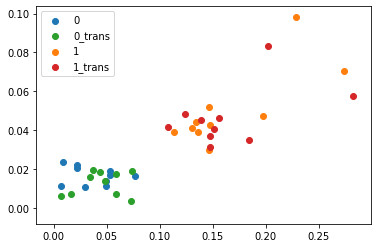

In [8]:
# Fourier descriptors of original images and transformed images
f1 = 3
f2 = 5
f_div = 1
FD_0_orig, FD_1_orig = get_fourier_descriptor(zeros_im, ones_im, f1, f2, f_div)
FD_0, FD_1 = get_fourier_descriptor(im_af0, im_af1, f1, f2, f_div)

# Superimposed plot of original and transformed to test invariances
zeros = plt.scatter(FD_0_orig[:,0],FD_0_orig[:,1]) 
ones = plt.scatter(FD_1_orig[:,0],FD_1_orig[:,1])
zeros_tf = plt.scatter(FD_0[:,0],FD_0[:,1]) 
ones_tf = plt.scatter(FD_1[:,0],FD_1[:,1])
plt.legend((zeros,zeros_tf,ones,ones_tf), ("0","0_trans","1", "1_trans"))

From the result of superimposed plot we can see the transformed data have similar clusters compared to the original one so it is invariate to these three transformations.     
The reason why they are not totally same is because of the image deviation after rotation and scaling.

### 1.3 Additional method(s)

## 1. Region-based object classification

### 1.1 Compacity and rectangularity

We have decided to use compacity and rectangularity as region-based descriptors. Moreover, the first one is invariant in translation, rotation, and scaling. Since compacity is highly sensitive to the definition of area and perimeter, we have selected the longest contour. 

In [9]:
def compacity(im):
    im = im.copy()
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # sort contours
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    
    c = contours[0] # longest contour
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    return (perimeter ** 2)/area, area, perimeter # must be bigger/equal than 4PI

In [10]:
def rectangularity(im):
    im = im.copy()
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    
    c = contours[0] # longest contour
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)
    area_rect = float(w * h)
    return area/area_rect

### 1.2 Elongation(Eclipse fitted)

This method get the feature of proportion between major axis length and minor axis length as the feature to distinguish two objects.  
We can see the proportion of 0s is smaller than 1s in most cases.  

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.



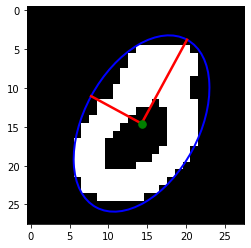

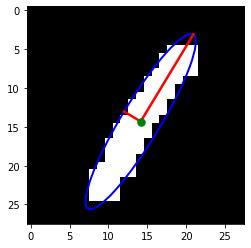

In [11]:
elongation_plot(zeros_im[0])
elongation_plot(ones_im[0])

In [12]:
def cal_major_minor_axis(img):
    '''
        Args: 
            img: input image
        output:
            the proportion between major axis length and minor axis length
    '''
    label_img = label(img)
    [props] = regionprops(label_img)
    return [props.major_axis_length/props.minor_axis_length]

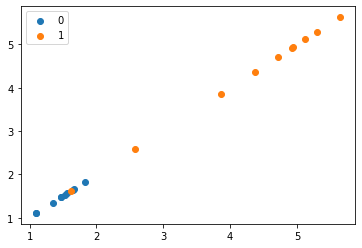

In [13]:
# get elongation of two digits
axis_length_zeros=[]
axis_length_ones=[]

for im0, im1 in zip(zeros_im,ones_im):
    axis_length_zeros.append(cal_major_minor_axis(im0))
    # Perform opening to remove noise in images of 1, particularly in 1_8.png
    el = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    axis_length_ones.append(cal_major_minor_axis(ndimage.binary_opening(im1,el)))
    
# plot
plt.scatter(np.array(axis_length_zeros), np.array(axis_length_zeros))
plt.scatter(np.array(axis_length_ones), np.array(axis_length_ones))
plt.legend(("0","1"))
plt.show()

The result is as our expected that the proportion of 1s are larger than 0s.   
But there are one outlier which is 1_5.png that has different writing of 1s making the proportion relatively smaller.

## 2. Contour-based object classification

### 1.1 Distance map of contours

We take a random image in two clusters as our distance map to compare them to other images to get similarity.  
We use two features, i.e, the distance to distance map of zeros and ones to generate clusters.

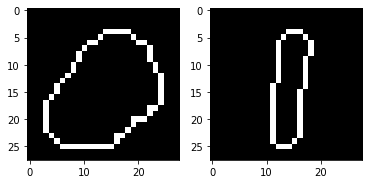

In [14]:
# Contour detection
contours = np.array(measure.find_contours(ones_im[6], 0))[0]
cont_1 = np.zeros_like(ones_im[0])
cont_1[contours[:,0].astype(int),contours[:,1].astype(int)]=1

contours = np.array(measure.find_contours(zeros_im[7], 0))[0]
cont_0 = np.zeros_like(zeros_im[0])
cont_0[contours[:,0].astype(int),contours[:,1].astype(int)]=1


fig, axes = plt.subplots(1,2)
axes[0].imshow(cont_0, cmap ='gray')
axes[1].imshow(cont_1, cmap ='gray')
plt.show()

In [15]:
# Chamfer distance maps
distance_map_0 = morphology.distance_transform_cdt(1-cont_0)
distance_map_1 = morphology.distance_transform_cdt(1-cont_1)

fig, axes = plt.subplots(1,2)
axes[0].imshow(distance_map_0, cmap ='gray')
axes[1].imshow(distance_map_1, cmap ='gray')
plt.show()

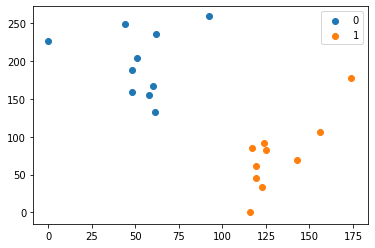

In [16]:
# Apply distance maps to get distance of zeros and ones
distance_zeros=[]
distance_ones=[]

# get distance to distance_map_0 and distance_map_1 respectively 
for im0, im1 in zip(zeros_im, ones_im):
    contours0 = np.array(measure.find_contours(im0, 0))[0]
    cont_0 = np.zeros_like(zeros_im[0])
    cont_0[contours0[:,0].astype(int),contours0[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_0))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_0))
    distance_zeros.append([distance_0,distance_1])
    
    contours1 = np.array(measure.find_contours(im1, 0))[0]
    cont_1 = np.zeros_like(ones_im[0])
    cont_1[contours1[:,0].astype(int),contours1[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_1))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_1))
    distance_ones.append([distance_0,distance_1])
    
distance_zeros = np.array(distance_zeros)
distance_ones = np.array(distance_ones)

#Plot results using the two features
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.legend(("0","1"))
plt.show()

We can see the distance map of contours can distinguish zeros and ones very great.   
The problem is that the result is affected by the choice of choosing the images as our distance map to test similarity.

### 1.2 Freeman Code

To compute the similarity between objects and therefore described them, we have used the chain code or freeman code. The idea was to code the contour and represent it as a series of characteristics. Therefore to compute the similarity between 2 objects, we have used as metric the mean edition distance.

However, we can see from the below plot that the result is not one of the best since we were able to cluster well just the 0s.

In [17]:
# Calculate chain codes for images and plot results

chain_zeros = []
chain_ones = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    # Calculate chain code
    chain_zeros.append(chain_code(img0))
    chain_ones.append(chain_code(img1))

# Combine all chain codes
chains = []
chains.append(chain_zeros)
chains.append(chain_ones)
chains = np.array(chains).reshape(20,-1)

In [18]:
# Calculate chain code edition distances
L = []
D = []
ED = []
for c in chains:
    temp = []
    L.append(len(c[0]))
    for cref in chains:
        
        # mean edition distance between each pair
        temp.append(editDistance(cref[0], c[0]))
        ED.append(temp[-1])
    D.append(np.mean(temp))

D = np.array(D)

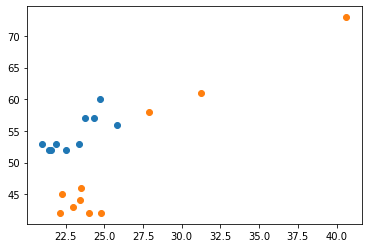

In [19]:
for i in range(2):
    plt.scatter(D[i*10:(i+1)*10],L[i*10:(i+1)*10])

In [20]:
# Use PCA on edition distance matric
ED = np.array(ED)
ED_data = ED.reshape(20,-1)

pca = decomposition.PCA(2) 
projected = pca.fit_transform(ED_data)
plt.scatter(projected[:10,0], projected[:10,1])
plt.scatter(projected[10:,0], projected[10:,1])
plt.legend(["0", "1"])

## 3. Other methods

### 3.1 Morphological Skeleton

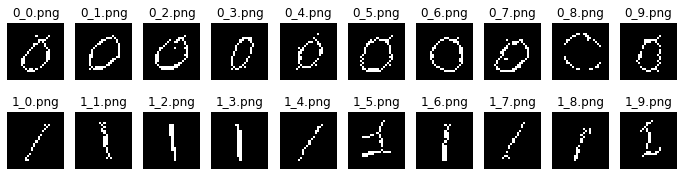

In [21]:
# Skeletonize images
Sr_zeros_im = []
Sr_ones_im = []
for im0, im1 in zip(zeros_im, ones_im):
    skel0 = skeletonize(im0)
    Sr_zeros_im.append(skel0) 
    skel1 = skeletonize(im1)
    Sr_ones_im.append(skel1)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [22]:
# plot distance maps with mean skeleton
mean_skel0 = np.array(np.mean(Sr_zeros_im,0))
mean_skel1 = np.array(np.mean(Sr_ones_im,0))
mean_skel0[mean_skel0>0] = 1
mean_skel1[mean_skel1>0] = 1

# Chamfer distance map
distance_map_0 = morphology.distance_transform_cdt(1-mean_skel0)
# plot
fig, axes = plt.subplots(1,2)
axes[0].imshow(distance_map_0, cmap ='gray')
axes[1].imshow(distance_map_1, cmap ='gray')
plt.show()

In [23]:
# Calculate image distances
distance_zeros=[]
for im in zeros_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_zeros.append([distance_0,distance_1])
distance_zeros = np.array(distance_zeros)
# print(distance_zeros)
distance_ones=[]
for im in ones_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_ones.append([distance_0,distance_1])
distance_ones = np.array(distance_ones)
# print(distance_ones)

# plot distances from mean skeletons of 0s and 1s
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

### 3.2 PCA


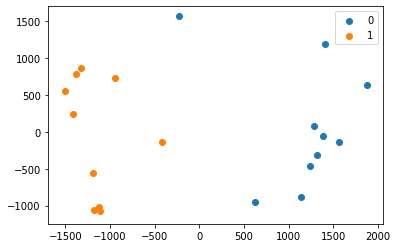

In [24]:
zeros_im_data = zeros_im.reshape(10,-1)
ones_im_data = ones_im.reshape(10,-1)
digits=np.concatenate((zeros_im_data,ones_im_data),axis = 0)

pca = decomposition.PCA(2) 
projected = pca.fit_transform(digits)
plt.scatter(projected[:10,0], projected[:10,1])
plt.scatter(projected[10:,0], projected[10:,1])
plt.legend(["0", "1"])
plt.show()

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

In [25]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# Binarize and scale the values
twos_im[twos_im>0] = 255
threes_im[threes_im>0] = 255

### 2.1 Fourier discriptors and conclusion


The fourier disriptors works with 2 digits expect 3 outliers because the writing of 2 and 3 is more complicated than 0 and 1

In [26]:
# choosing fourier discriptors 1 and 3 and use 8 to divide
FD2, FD3 = get_fourier_descriptor(twos_im, threes_im, 1, 3, 8)
plt.scatter(FD2[:,0], FD2[:,1])
plt.scatter(FD3[:,0], FD3[:,1])
plt.legend(("2", "3"))
plt.show()

Now we superimpose the culster of 0s and 1 to 2s and 3s

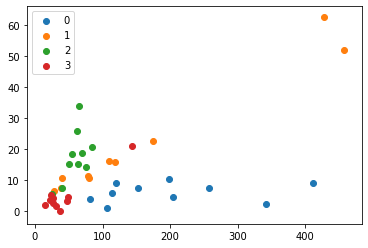

In [27]:
# choosing fourier discriptors 1 and 3 and use 8 to divide
f1 = 1
f2 = 3
f_div = 8

# zeros and ones
FD0, FD1 = get_fourier_descriptor(zeros_im, ones_im, f1, f2, f_div)

# twos and threes
FD2, FD3 = get_fourier_descriptor(twos_im, threes_im, f1, f2, f_div)
plt.scatter(FD0[:,0], FD0[:,1])
plt.scatter(FD1[:,0], FD1[:,1])
plt.scatter(FD2[:,0], FD2[:,1])
plt.scatter(FD3[:,0], FD3[:,1])
plt.legend(["0","1","2","3"])

The result of clustering four digits with 2 fourier discriptors is not satisfactory.  
We try to use 3 fourier discriptors to see if it is works.

In [28]:
f1 = 1
f2 = 3
f3 = 8
f_div = 5

FD_0, FD_1, FD_2, FD_3 = get_fourier_descriptor_3(zeros_im, ones_im, twos_im, threes_im, f1, f2, f3, f_div, plot = False)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(FD_0[:,0], FD_0[:,1],FD_0[:,2],'green')
ax.scatter(FD_1[:,0], FD_1[:,1],FD_1[:,2],'red')
ax.scatter(FD_2[:,0], FD_2[:,1],FD_2[:,2],'yellow')
ax.scatter(FD_3[:,0], FD_3[:,1],FD_3[:,2],'blue')
plt.legend(["0","1","2","3"])
plt.show()

It is clear cluster of 1s, 2s are not sepearate. But it works better in three dimensions than two features. So the performance will increase if we add more fourier descriptors to cluster. 

We are trying to hybrid the fourier descriptors to other methods to see if it gives us better result because elongation can separate 1s from 2s and 3s.

#### Hybrid method: two fourier discriptor features + Elongation

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.



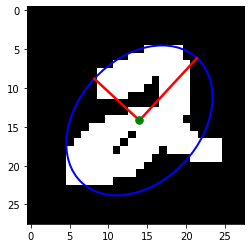

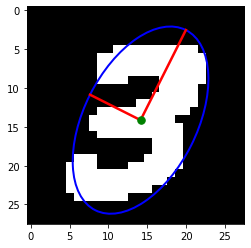

In [29]:
elongation_plot(twos_im[0])
elongation_plot(threes_im[0])

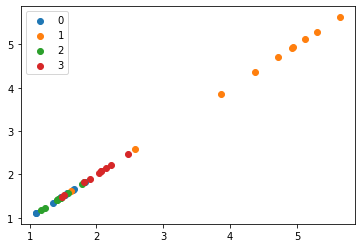

In [30]:
# get elongation of four digits

axis_length_twos = []
axis_length_threes = []
for im2, im3 in zip( twos_im,threes_im):

    # Perform opening to remove noise in images of 1, particularly in 1_8.png
    el = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    axis_length_twos.append(cal_major_minor_axis(ndimage.binary_opening(im2,el)))
    axis_length_threes.append(cal_major_minor_axis(ndimage.binary_opening(im3,el)))
    
plt.figure()
zeros = plt.scatter(axis_length_zeros, axis_length_zeros)
ones = plt.scatter(axis_length_ones, axis_length_ones)
twos = plt.scatter(np.array(axis_length_twos), np.array(axis_length_twos))
threes = plt.scatter(np.array(axis_length_threes), np.array(axis_length_threes))

plt.legend((zeros,ones,twos, threes),("0","1","2","3"))
plt.show()

We can see 1s are sepearated from 2s and 3s in elongation which will improve of result of fourier descriptors since it has bad performance in 1s.

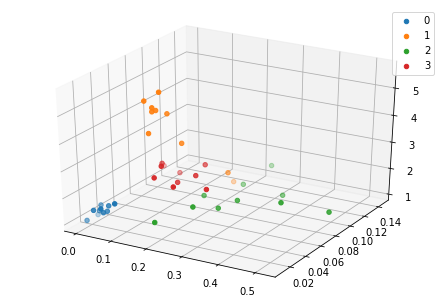

In [31]:
f1 = 3
f2 = 5
f3 = 8
f_div = 1


FD_0, FD_1, FD_2, FD_3 = get_fourier_descriptor_3(zeros_im, ones_im, twos_im, threes_im, f1, f2, f3, f_div, plot = False)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(FD_0[:,0], FD_0[:,1],axis_length_zeros,'green')
ax.scatter(FD_1[:,0], FD_1[:,1],axis_length_ones,'red')
ax.scatter(FD_2[:,0], FD_2[:,1],axis_length_twos,'yellow')
ax.scatter(FD_3[:,0], FD_3[:,1],axis_length_threes,'blue')
plt.legend(["0","1","2","3"])
plt.show()

Now the four digits are mostly separated into four clusters except two outliers of 1s which corresponds to the different writing style ones.

### 2.2 Additional method(s) and conclusion TODO//

### PCA
Apparently does not work...

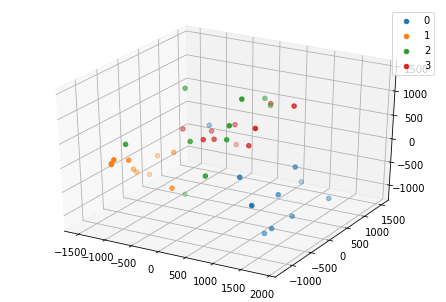

In [32]:
zeros_im_data = zeros_im.reshape(10,-1)
ones_im_data = ones_im.reshape(10,-1)
twos_im_data = twos_im.reshape(10,-1)
threes_im_data = threes_im.reshape(10,-1)
digits=np.concatenate((zeros_im_data,ones_im_data,twos_im_data,threes_im_data),axis = 0)

pca = decomposition.PCA(3) 
projected = pca.fit_transform(digits)
fig = plt.figure()
ax = Axes3D(fig)
for i in range(4):
    ax.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2])
plt.legend(["0", "1", "2", "3"])

### Skeletonize
### TODO: How do we extract two features now if we apply distance map there will be 4 distances for each image?

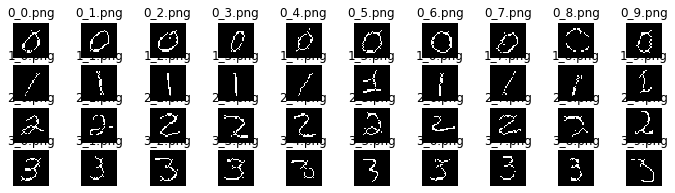

In [33]:
# Skeletonize images
Sr_zeros_im = []
Sr_ones_im = []
Sr_twos_im = []
Sr_threes_im = []
for im0, im1, im2, im3, in zip(zeros_im, ones_im, twos_im, threes_im):
    Sr_zeros_im.append(skeletonize(im0)) 
    Sr_ones_im.append(skeletonize(im1))
    Sr_twos_im.append(skeletonize(im2))
    Sr_threes_im.append(skeletonize(im3))

fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], Sr_twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], Sr_threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    

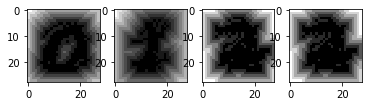

In [34]:
# plot distance maps with mean skeleton
mean_skel0 = np.array(np.mean(Sr_zeros_im,0))
mean_skel1 = np.array(np.mean(Sr_ones_im,0))
mean_skel2 = np.array(np.mean(Sr_twos_im,0))
mean_skel3 = np.array(np.mean(Sr_threes_im,0))

mean_skel0[mean_skel0>0] = 1
mean_skel1[mean_skel1>0] = 1
mean_skel2[mean_skel2>0] = 1
mean_skel3[mean_skel3>0] = 1

# Chamfer distance map
distance_map_0 = morphology.distance_transform_cdt(1-mean_skel0)
distance_map_1 = morphology.distance_transform_cdt(1-mean_skel1)
distance_map_2 = morphology.distance_transform_cdt(1-mean_skel2)
distance_map_3 = morphology.distance_transform_cdt(1-mean_skel3)

# plot
fig, axes = plt.subplots(1,4)
axes[0].imshow(distance_map_0, cmap ='gray')
axes[1].imshow(distance_map_1, cmap ='gray')
axes[2].imshow(distance_map_2, cmap ='gray')
axes[3].imshow(distance_map_2, cmap ='gray')
plt.show()

### Distance Map + Contour

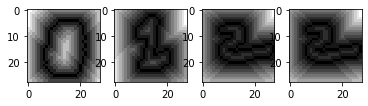

In [35]:
# Contour detection
contours = np.array(measure.find_contours(twos_im[6], 0))[0]
cont_2 = np.zeros_like(ones_im[0])
cont_2[contours[:,0].astype(int),contours[:,1].astype(int)]=1

contours = np.array(measure.find_contours(threes_im[8], 0))[0]
cont_3 = np.zeros_like(zeros_im[0])
cont_3[contours[:,0].astype(int),contours[:,1].astype(int)]=1

# Chamfer distance maps
distance_map_0 = morphology.distance_transform_cdt(1-cont_0)
distance_map_1 = morphology.distance_transform_cdt(1-cont_1)
# Chamfer distance maps
distance_map_2 = morphology.distance_transform_cdt(1-cont_2)
distance_map_3 = morphology.distance_transform_cdt(1-cont_3)

# plot
fig, axes = plt.subplots(1,4)
axes[0].imshow(distance_map_0, cmap ='gray')
axes[1].imshow(distance_map_1, cmap ='gray')
axes[2].imshow(distance_map_2, cmap ='gray')
axes[3].imshow(distance_map_2, cmap ='gray')
plt.show()

In [36]:
idx = -1
for imgs in [zeros_im, ones_im, twos_im, threes_im]:
    cor = 0
    err = 0
    idx += 1
    
    for img in imgs:
        # Align orientation
        contours0 = np.array(measure.find_contours(img, 0))[0]
        cont_0 = np.zeros_like(zeros_im[0])
        cont_0[contours0[:,0].astype(int),contours0[:,1].astype(int)]=1
        
        distance_0 = np.sum(np.multiply(distance_map_0, cont_0))
        distance_1 = np.sum(np.multiply(distance_map_1, cont_0))
        distance_2 = np.sum(np.multiply(distance_map_2, cont_0))
        distance_3 = np.sum(np.multiply(distance_map_3, cont_0))
        distance = [distance_0, distance_1, distance_2, distance_3]
        
        if idx == distance.index(min(distance)):
            cor += 1
        else:
            err += 1
    print("The accuracy of recognizing ", idx, " is ", cor/len(imgs)," with ", err, " errors")

The accuracy of recognizing  0  is  1.0  with  0  errors
The accuracy of recognizing  1  is  0.4  with  6  errors
The accuracy of recognizing  2  is  0.3  with  7  errors
The accuracy of recognizing  3  is  1.0  with  0  errors


C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.



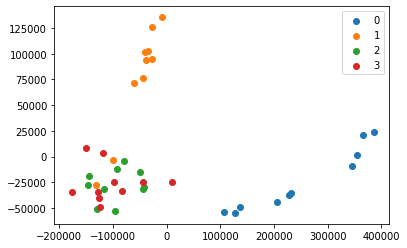

In [37]:
imgs = np.concatenate((zeros_im, ones_im, twos_im, threes_im), axis = 0)
D = []
ct = 0
img_al = []
for img in imgs:
    [props] = regionprops(img)
    img = rotate(img, -props.orientation)
    img_al.append(img)
img_al = np.array(img_al)
img_al.shape
Dist = []
Dist_mean = []
for imgref in img_al:
    imgref = ndimage.median_filter(imgref,size = 3)
    dm = get_distance_map(imgref)
    temp = []
    for img in img_al:
        temp.append(np.sum(np.multiply(dm, img)))
        Dist.append(temp[-1])
    Dist_mean.append(np.mean(temp))
Dist = np.array(Dist)
Dist_mean = np.array(Dist_mean)
Dist_data = Dist.reshape(40,-1)

pca = decomposition.PCA(2) 
projected = pca.fit_transform(Dist_data)

for i in range(4):
    plt.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1])
plt.legend(["0","1","2","3"])

In [38]:
# 3 PCA components
D = np.array(Dist)
D_data = D.reshape(40,-1)

pca = decomposition.PCA(3) 
projected = pca.fit_transform(D_data)

fig = plt.figure()
ax = Axes3D(fig)

for i in range(4):
    ax.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2])



In [39]:
Fd = pd.DataFrame([])
for i in range(4):    
    temp = (pd.DataFrame(np.array([projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2],np.ones([10])*i]).T,columns=['f1','f2','f3','label']))
    Fd = pd.concat([Fd,temp])
px.scatter_3d(Fd,x='f1',y='f2',z='f3',color='label')

### Projection

In [40]:
from scipy.signal import find_peaks

PP = []
PP_max = []
imgs = np.concatenate((zeros_im,ones_im, twos_im, threes_im), axis = 0)

for img in imgs:
    p1 = np.sum(img,0)
    p2 = np.sum(img,1)
    peaks1, _ = find_peaks(p1, height=0)
    peaks2, _ = find_peaks(p2, height=0)
    peaks3, _ = find_peaks(-p1, height=0)
    peaks4, _ = find_peaks(-p2, height=0)
# max peaks and troughs in projection
    PP_max.append([np.max(p1[peaks1]), np.max(p2[peaks2]),np.min(p1[peaks3]),np.min(p2[peaks4])])
# mean peaks and troughs in projection
    PP.append([np.mean(p1[peaks1]), np.mean(p2[peaks2]),np.mean(p1[peaks3]),np.mean(p2[peaks4])])

PP = np.array(PP)
PP_max = np.array(PP_max)

for i in range(4):
    plt.scatter(PP[i*10:(i+1)*10,2],PP[i*10:(i+1)*10,1])

pca = decomposition.PCA(2) 
projected = pca.fit_transform(PP[:,[2,1,0,3]])

# for i in range(4):
#     plt.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1])


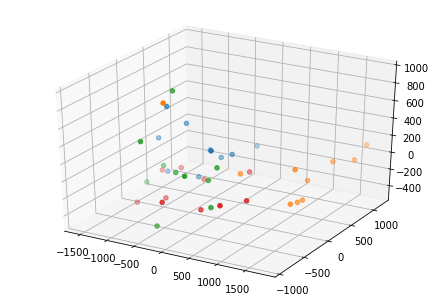

In [41]:
# 3 PCA components
pca = decomposition.PCA(3) 
projected = pca.fit_transform(PP[:,1:])

fig = plt.figure()
ax = Axes3D(fig)

for i in range(4):
    ax.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2])

Fd = pd.DataFrame([])
for i in range(4):    
    temp = (pd.DataFrame(np.array([projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2],np.ones([10])*i]).T,columns=['f1','f2','f3','label']))
    Fd = pd.concat([Fd,temp])
px.scatter_3d(Fd,x='f1',y='f2',z='f3',color='label')

### Freeman Code

In [42]:
# Calculate chain codes for images and plot results

chain_zeros = []
chain_ones = []
chain_twos = []
chain_threes = []

for img0, img1, img2, img3 in zip(zeros_im, ones_im, twos_im, threes_im):
    # Calculate chain codes
    chain_zeros.append(chain_code(img0))
    chain_ones.append(chain_code(img1))
    chain_twos.append(chain_code(img2))
    chain_threes.append(chain_code(img3))
# Combine all chain codes
chains = []
chains.append(chain_zeros)
chains.append(chain_ones)
chains.append(chain_twos)
chains.append(chain_threes)
chains = np.array(chains).reshape(40,-1)

In [43]:
# Calculate chain code edition distances
L = []
D = []
ED = []
for c in chains:
    temp = []
    L.append(len(c[0]))
    for cref in chains:
        # mean edition distance between each pair
        temp.append(editDistance(cref[0], c[0]))
        ED.append(temp[-1])
    D.append(np.mean(temp))

D = np.array(D)

# for i in range(4):
#     plt.scatter(D[i*10:(i+1)*10],L[i*10:(i+1)*10])

(1600,)


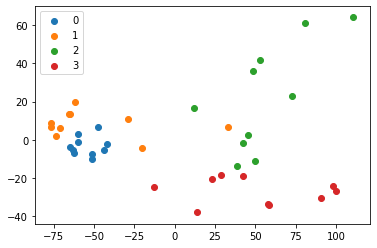

In [44]:
# Use PCA on edition distance matric: 2 coponents
ED = np.array(ED)
print(ED.shape)
ED_data = ED.reshape(40,-1)

pca = decomposition.PCA(2) 
projected = pca.fit_transform(ED_data)

for i in range(4):
    plt.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1])

plt.legend(["0","1","2","3"])

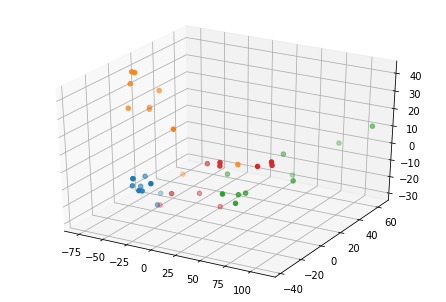

In [45]:
# 3 PCA components
ED = np.array(ED)
ED_data = ED.reshape(40,-1)

pca = decomposition.PCA(3) 
projected = pca.fit_transform(ED_data)

fig = plt.figure()
ax = Axes3D(fig)

for i in range(4):
    ax.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2])



In [46]:
Fd = pd.DataFrame([])
for i in range(4):    
    temp = (pd.DataFrame(np.array([projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1],projected[i*10:(i+1)*10,2],np.ones([10])*i]).T,columns=['f1','f2','f3','label']))
    Fd = pd.concat([Fd,temp])
px.scatter_3d(Fd,x='f1',y='f2',z='f3',color='label')

In [47]:
# Min/max axis
def cal_major_minor_axis(img):
#     label_img = label(img)
    [props] = regionprops(img)
    return [props.major_axis_length/props.minor_axis_length]


imgs = np.concatenate((zeros_im,ones_im, twos_im, threes_im), axis = 0)

MM = []
for img in imgs:
    img = ndimage.median_filter(img,size=3)
    MM.append(cal_major_minor_axis(img))


C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.

C:\Users\costa\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning:

regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.



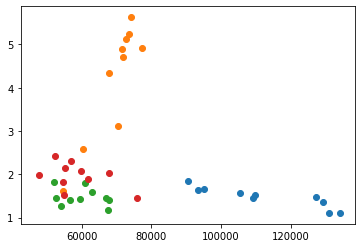

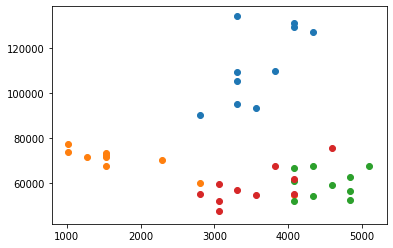

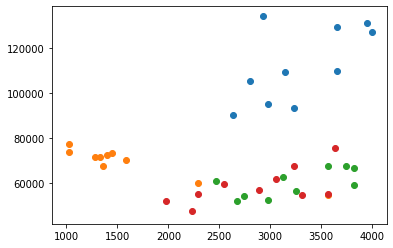

In [48]:
for i in range(4):
    # mean chamfer distance between pairs vs max/min axes
    plt.scatter(Dist_mean[i*10:(i+1)*10],MM[i*10:(i+1)*10])
plt.show()
for i in range(4):
    # max projection peaks in dimension 1 vs mean chamfer distance
    plt.scatter(PP_max[i*10:(i+1)*10,1],Dist_mean[i*10:(i+1)*10])
plt.show()

for i in range(4):
    # mean projection peaks in dimension 1 vs mean chamfer distance
    plt.scatter(PP[i*10:(i+1)*10,1],Dist_mean[i*10:(i+1)*10])


In [49]:
def get_moment(img,i,j):
    pts = np.nonzero(img) 
    N = (np.max(pts)) + 1
    pc = np.zeros([N,N])
    pc[pts[0],pts[1]] = 1
    M00 = 0
    M10 = 0
    M01 = 0
    out = 0
    for k in pts[0]:
        for l in pts[1]:
            M00 = M00 + pc[k,l]
            M10 = M10 + (k) * pc[k,l]      
            M01 = M01 + (l) * pc[k,l] 
    kbar = M10/M00
    lbar = M01/M00
    for k in pts[0]:
        for l in pts[1]:
            out = out + (k-kbar)**i * (l-lbar)**j * pc[k,l]           
    return out, kbar, lbar

imgs = np.concatenate((zeros_im,ones_im, twos_im, threes_im), axis = 0)
Moments22 = []
Moments11 = []
Moments20 = []
Moments21 = []

for img in imgs:
    Moments11.append(get_moment(img,1,1))
    Moments20.append(get_moment(img,2,0))
    Moments21.append(get_moment(img,2,1))
    Moments22.append(get_moment(img,2,2))

Moments11 = np.array(Moments11)
Moments20 = np.array(Moments20)
Moments21 = np.array(Moments21)
Moments22 = np.array(Moments22)


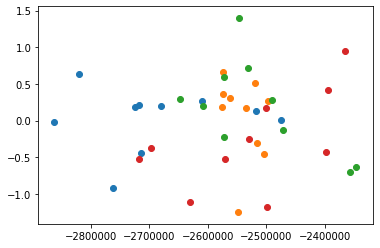

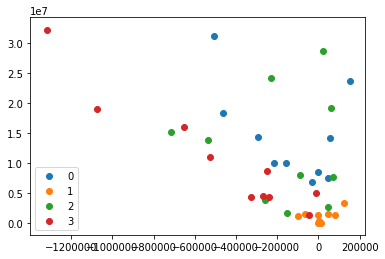

In [50]:
pca = decomposition.PCA(3) 
Moments = np.concatenate((Moments11, Moments20, Moments21, Moments22),0)

projected = pca.fit_transform(Moments)
# projectedM = pca.fit_transform(ED.reshape(40,-1))

for i in range(4):
#     plt.scatter(projectedM[i*10:(i+1)*10,1],C[i*10:(i+1)*10,1])
    plt.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1])
plt.show()

for i in range(4):
#     plt.scatter(projectedM[i*10:(i+1)*10,1],C[i*10:(i+1)*10,1])
    plt.scatter(Moments21[i*10:(i+1)*10,0],Moments22[i*10:(i+1)*10,0])

plt.legend(['0','1','2', '3'])

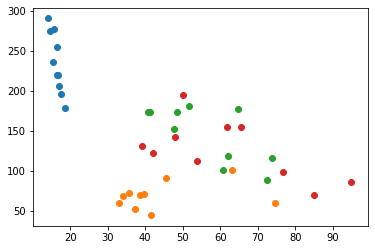

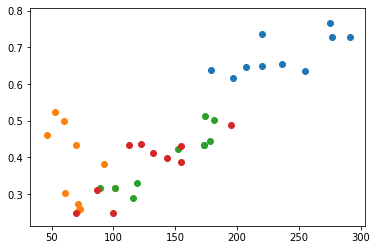

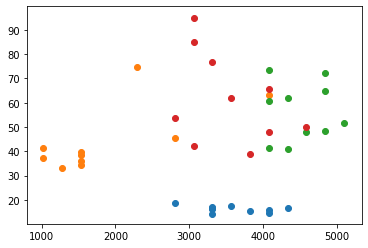

In [51]:
# compacity and rectangularity
imgs = np.concatenate((zeros_im,ones_im, twos_im, threes_im), axis = 0)

C = []
R = []
for img in imgs:
    C.append(compacity(img))
    R.append(rectangularity(img))
C = np.array(C)
R = np.array(R)

for i in range(4):
    plt.scatter(C[i*10:(i+1)*10,0],C[i*10:(i+1)*10,1])
plt.show()
for i in range(4):
    plt.scatter(C[i*10:(i+1)*10,1],R[i*10:(i+1)*10])
plt.show()
for i in range(4):
    plt.scatter(PP_max[i*10:(i+1)*10,1],C[i*10:(i+1)*10,0])

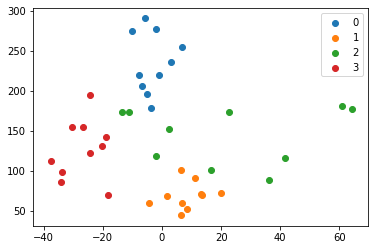

In [52]:
# Best one so far
pca = decomposition.PCA(3) 
projected = pca.fit_transform(ED.reshape(40,-1))
for i in range(4):
    plt.scatter(projected[i*10:(i+1)*10,1],C[i*10:(i+1)*10,1])
plt.legend(['0','1','2', '3'])